# Lesson 7.2 Mini Batch K-Means与DBSCAN密度聚类

&emsp;&emsp;除了K-Means快速聚类意外，还有两种常用的聚类算法，其一是能够进一步提升快速聚类的速度的Mini Batch K-Means算法，其二则是能够和K-Means快速聚类形成性能上互补的算法DBSCAN密度聚类。

In [1]:
# 科学计算模块
import numpy as np
import pandas as pd

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# 自定义模块
from ML_basic_function import *

# K-Means
from sklearn.cluster import KMeans

## 一、Mini Batch K-Means算法原理与实现

&emsp;&emsp;K-Means算法作为最常用的聚类算法，在长期的使用过程中也诞生了非常多的变种，典型的如提高迭代稳定性的二分K均值法、能够显著提升算法执行速度的Mini Batch K-Means，由于聚类算法的稳定性可以通过k-means++以及多次迭代选择最佳划分方式等方法解决，此处重点介绍Mini Batch K-Means算法。

&emsp;&emsp;顾名思义，所谓Mini Batch K-Means算法，就是在K-Means基础上增加了一个Mini Batch的抽样过程，并且每轮迭代中心点时，不在带入全部数据、而是带入抽样的Mini Batch进行计算。即每一轮的迭代操作更新为        
&emsp;&emsp;（1）.从数据集中随机抽取一些数据形成小批量，把他们分配给最近的质心；        
&emsp;&emsp;（2）.根据小批量数据划分情况，更新质心；

&emsp;&emsp;此处可以用梯度下降和小批量（Mini Batch）梯度下降之间的差异进行类比，梯度下降过程中，我们带入全部数据构造损失函数，相当于带入全部数据进行参数的更新，就类似于K-Means带入每个簇的全部数据进行中心点位置计算，而在小批量梯度下降过程中，实际上我们是借助小批数据构造损失函数并对参数进行更新，就类似于Mini Batch K-Means中利用小批数据更新中心点。

&emsp;&emsp;而Mini Batch K-Means的有效性，其实也和小批量梯度下降的有效性类似，那就是对于一组规律连贯的数据集来说，小批量数据能够很大程度反映整体数据集规律，因此带入小批量数据进行计算是有效的。此外，Mini Batch K-Means相比K-Means的优劣势，也和小批量梯度下降对比梯度下降过程类似，采用小批数据带入进行计算能够极大缩短单次运算时间，因此迭代速度会更快，但由于小批量数据还是和整体数据之间存在差异，因此每次计算结果的精度不如带入整体数据的计算结果。不过对于K-Means是否会落入局部最小值陷阱，我们可以通过k-means++以及重复多次训练模型来解决，因此Mini Batch K-Means并不用承担跨越局部最小值陷阱的职责，所以Mini Batch K-Means对比K-Means，其实就相当于牺牲了部分精度来换取聚类速度。而聚类算法毕竟不是有监督学习算法，因此如果是面对海量数据的聚类，我们是可以考虑牺牲部分精度来换取聚类执行的速度的（当然这也要视情况而定）。

> 此处所谓小批量聚类精度不足，指的是小批量聚类和K-Means聚类结果上的差异，一般我们会认为K-Means聚类是精准的，而小批量聚类如果出现了和K-Means聚类不同的结果，则说明小批量聚类出现了误差，也就是精度不足。

> 更多Mini Batch K-Means算法的信息，查阅“[Web Scale K-Means clustering” D. Sculley](https://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf), Proceedings of the 19th international conference on World wide web (2010)

&emsp;&emsp;接下来尝试调用相关评估器进行Mini Batch K-Means聚类：

In [2]:
from sklearn.cluster import MiniBatchKMeans

我们发现，MiniBatchKMeans中部分参数和K-Means中参数不同，我们针对这些不同的参数来进行解释

In [3]:
MiniBatchKMeans?

Init signature:
MiniBatchKMeans(
    n_clusters=8,
    *,
    init='k-means++',
    max_iter=100,
    batch_size=100,
    verbose=0,
    compute_labels=True,
    random_state=None,
    tol=0.0,
    max_no_improvement=10,
    init_size=None,
    n_init=3,
    reassignment_ratio=0.01,
)
Docstring:     
Mini-Batch K-Means clustering.

Read more in the :ref:`User Guide <mini_batch_kmeans>`.

Parameters
----------

n_clusters : int, default=8
    The number of clusters to form as well as the number of
    centroids to generate.

init : {'k-means++', 'random'} or ndarray of shape             (n_clusters, n_features), default='k-means++'
    Method for initialization

    'k-means++' : selects initial cluster centers for k-mean
    clustering in a smart way to speed up convergence. See section
    Notes in k_init for more details.

    'random': choose k observations (rows) at random from data for
    the initial centroids.

    If an ndarray is passed, it should be of shape (n_clusters, n_fe

|Name|Description|      
|:--:|:--:|      
|batch_size|小批量抽样的数据量|      
|compute_labels|在聚类完成后，是否对所有样本进行类别计算|
|max_no_improvement|当SSE不发生变化时，质心最多再迭代多少次|
|init_size|用于生成初始中心点的样本数量|	
|reassignment_ratio|某比例，数值越大、样本数越少的簇被重新计算中心点的概率就越大|	

&emsp;&emsp;能够发现，MiniBatchKMeans在参数设置上和K-Means有两方面差异：        
&emsp;&emsp;其一是在迭代收敛条件上，通过查看说明文档我们不难发现，MiniBatchKMeans主要通过max_no_improvement和max_iter两个参数来控制收敛，在默认情况下不采用tol参数。其根本原因在于小批量聚类往往需要迭代很多轮，因而出实际未收敛、但现两次相邻的迭代结果中SSE变化值小于tol的情况的概率会显著增加，因此此时我们不能以tol条件作为收敛条件；              
&emsp;&emsp;其二，是在控制结果精度上，尽管小批量聚类是用精度换速度，但仍然提供了可以提升聚类精度的参数，也就是reassignment_ratio，当发现聚类结果不尽如人意时，可以适当提升该参数的取值。

&emsp;&emsp;接下来，尝试调用相关评估器进行建模：

In [14]:
mbk = MiniBatchKMeans(n_clusters=2)

In [15]:
np.random.seed(23)
X, y = arrayGenCla(num_examples = 20, num_inputs = 2, num_class = 2, deg_dispersion = [2, 0.5])

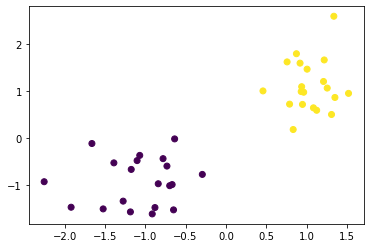

In [16]:
plt.scatter(X[:, 0],X[:, 1],c=y)

In [17]:
mbk.fit(X)

MiniBatchKMeans(n_clusters=2)

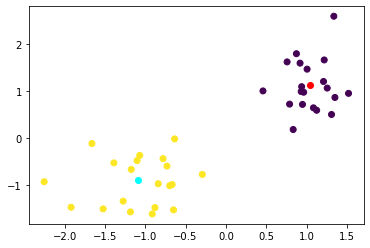

In [18]:
# 观察聚类结果
plt.scatter(X[:, 0], X[:, 1], c=mbk.labels_)
plt.plot(mbk.cluster_centers_[0, 0], mbk.cluster_centers_[0, 1], 'o', c='red')
plt.plot(mbk.cluster_centers_[1, 0], mbk.cluster_centers_[1, 1], 'o', c='cyan')

我们发现，在简单数据集的聚类过程中，MiniBatchKMeans和KMeans并没有太大差异，接下来我们尝试在更大的数据集上来进行聚类，测试二者的精度和运算速度：

In [40]:
np.random.seed(23)
X, y = arrayGenCla(num_examples = 1000000, num_inputs = 10, num_class = 5, deg_dispersion = [4, 1])

In [41]:
km = KMeans(n_clusters=5, max_iter=1000)
mbk = MiniBatchKMeans(n_clusters=5, max_iter=1000)

In [42]:
# 导入时间模块
import time

In [43]:
# K-Means聚类用时
t0 = time.time()
km.fit(X)
t_batch = time.time() - t0
t_batch

12.087070941925049

In [44]:
# MiniBatchKMeans聚类用时
t0 = time.time()
mbk.fit(X)
t_batch = time.time() - t0
t_batch

3.6028831005096436

能够发现，MiniBatchKMeans聚类速度明显快于K-Means聚类，接下来查看二者SSE来对比其精度：

In [47]:
km.inertia_

49994316.22276671

In [48]:
mbk.inertia_

50166895.159873486

能够发现，MiniBatchKMeans精度略低于K-Means，但整体结果相差不大，基本可忽略不计，当然这也是因为当前数据集分类性能较好的原因。不过经此也可验证MiniBatchKMeans聚类的有效性。一般来说，对于2万条以上的数据集，MiniBatchKMeans聚类的速度优势就会逐渐显现。

&emsp;&emsp;当然，如果希望更进一步提高迭代速度，可以适度减少batch_size、减少reassignment_ratio、max_no_improvement这三个参数，不过代价就是聚类的精度可能会进一步降低，而如果希望提高精度，则可以提升reassignment_ratio参数，不过相应的，运行时间将会有所提升。

## 二、DBSCAN密度聚类基本原理与实践

### 1.K-Means聚类算法的算法特性

&emsp;&emsp;尽管MiniBatchKMeans能够有效提高聚类速度、提升聚类效率，但从最终聚类效果上来看，MiniBatchKMeans和K-Means聚类算法仍然属于同一类聚类——假设簇的边界是凸形的聚类。换而言之，就是这种聚类能够较好的捕捉圆形/球形边界（直线边界可以看成是大直径的圆形边界），而对于非规则类边界，则无法进行较好的聚类，当然这也是和K-Means聚类的核心目的：让更相近同一个中线点的数据属于一个簇，息息相关。但有些时候，更接近同一个中心点的数据却不一定应该属于一个簇，例如如下情况：

In [11]:
from sklearn.datasets import make_moons

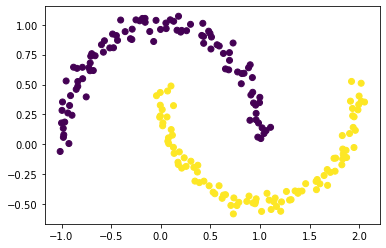

In [12]:
X, y = make_moons(200, noise=0.05, random_state=24)
plt.scatter(X[:,0], X[:,1], c = y)

其中make_moons函数是datasets模块中创造数据集的函数，默认创建月牙形数据分布的数据集，并且noise参数取值越小、数据分布越贴近月牙形状。当然此时我们发现，上述数据集明显可分为两个簇，但两个簇的边界却不是凸型的。此时如果我们用K-Means对其进行聚类，则会得到如下结果：

In [13]:
km = KMeans(n_clusters=2)
km.fit(X)

KMeans(n_clusters=2)

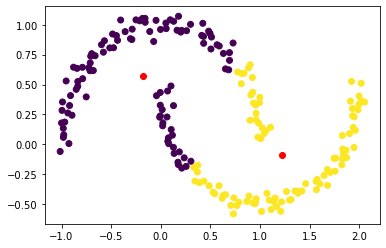

In [14]:
plt.scatter(X[:,0], X[:,1], c = km.labels_)
plt.plot(km.cluster_centers_[:,0], km.cluster_centers_[:,1], 'ro')

从上述结果中也能很明显的看出K-Means聚类的凸型边界，但很明显，此时聚类结果并不合理，上图中有多处彼此相邻但却不属于同一类的情况出现。此时如果我们希望捕获上述非凸的边界，则需要使用一种基于密度的聚类方法，也就是我们将要介绍的DBSCAN密度聚类。

> 不过此处需要强调的是，尽管上述情况主观判断不太合理，但最终上述结果是否可用，还是需要结合实际业务进行考虑，这也是无监督学习算法没有统一的评价标准的具体表现，此处我们只能说K-Means算法性能使得其无法捕获不规则边界，但这个特性导致的结果好坏无法直接通过数据结果进行得出。

### 2.DBSCAN密度聚类基本原理

&emsp;&emsp;和K-Means依据中心点划分数据集的思路不同，DBSCAN聚类则是试图通过寻找特征空间中点的分布密度较低的区域作为边界，并进一步以此划分数据集。正是因为以低密度区域作为边界，DBSCAN最终对数据的划分边界很有可能是不规则的，从而突破了K-Means依据中心点划分数据集从而使得边界是凸型的限制。

&emsp;&emsp;当然对于给予密度的聚类算法，最重要的是给出密度的相关的定义。在DBSCAN中，我们通过两个概念和密度密切相关：分别是半径（eps）与半径范围内点的个数（num_samples）。对于数据集中任意一个点，只要给定一个eps，就能算出对应的num_samples，例如对于下述A点，在一个eps范围内，num_samples为7（包括自己）。

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gsczpozxc0j30m80gsjw5.jpg" alt="1" style="zoom:30%;" />

&emsp;&emsp;当然，eps越小、num_samples越大，则说明该点所在区域密度较高。当然，我们可以据此设置一组参数，即半径（eps）和半径范围内至少包含多少点（min_samples）作为评估指标，来对数据集中不同的点进行密度层面的分类：例如我们令eps=Eps（某个数），min_samples=6，并且如果某点在一个Eps范围内包含的点的个数大于min_samples，则称该点为核心点（core point），如下图中的A点；而如果某个点不是核心点，但是在某个核心点的一个eps领域内，则称该点为边界点，例如下图B点；而如果某点既不是核心点也不是边界点，则成该点为噪声点，如下图的C点。

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gsd01ibvqbj611q0jigxp02.jpg" alt="1" style="zoom:30%;" />

&emsp;&emsp;当我们对数据集中的所有点完成上述三类的划分之后，接下来，我们一个eps范围内的核心点化为一个簇，并且将边界点划归到一个临近的核心点所属簇中，并且抛弃噪声点，最终完成数据集整体的划分。而实际上DBSCAN整体划分过程，就是在将高密度区域划分成一个簇，将低密度区域视作不同簇的分界线。

&emsp;&emsp;很明显，在DBSCAN聚类中，核心参数就是eps和min_samples，其不仅可以控制高低密度区域的划分，并且可以实际控制聚成几类的结果：当eps较小而min_samples较大时，核心点的定义较为严格、同一个簇对簇内的密度要求更高，此时更容易划分出多个簇；反之，划分成的簇的个数可能会更少。接下来我们尝试在sklearn进行DBSCAN建模试验。

### 3.DBSCAN密度聚类的sklearn实现

In [2]:
from sklearn.cluster import DBSCAN

In [4]:
DBSCAN?

Init signature:
DBSCAN(
    eps=0.5,
    *,
    min_samples=5,
    metric='euclidean',
    metric_params=None,
    algorithm='auto',
    leaf_size=30,
    p=None,
    n_jobs=None,
)
Docstring:     
Perform DBSCAN clustering from vector array or distance matrix.

DBSCAN - Density-Based Spatial Clustering of Applications with Noise.
Finds core samples of high density and expands clusters from them.
Good for data which contains clusters of similar density.

Read more in the :ref:`User Guide <dbscan>`.

Parameters
----------
eps : float, default=0.5
    The maximum distance between two samples for one to be considered
    as in the neighborhood of the other. This is not a maximum bound
    on the distances of points within a cluster. This is the most
    important DBSCAN parameter to choose appropriately for your data set
    and distance function.

min_samples : int, default=5
    The number of samples (or total weight) in a neighborhood for a point
    to be considered as a core point. T

其中核心参数就是上面介绍的eps和min_samples，其他参数都是距离计算相关和最近邻计算相关的参数，暂时可以不做考虑。接下来围绕上述月牙型数据进行建模：

In [15]:
# 实例化模型
DB = DBSCAN(eps=0.3, min_samples=10)

In [16]:
# 训练模型
DB.fit(X)

DBSCAN(eps=0.3, min_samples=10)

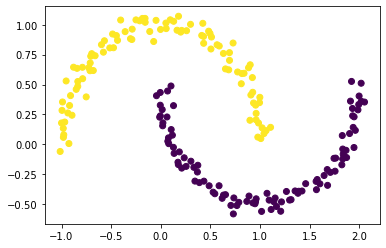

In [18]:
# 查看聚类结果
plt.scatter(X[:,0], X[:,1], c = DB.labels_)

&emsp;&emsp;能够发现，DBSCAN通过捕获低密度区域作为聚类划分的边界线，使得最终聚类结果和预想中的情况更加接近。接下来我们尝试在上一小节定义的数据集中执行DBSCAN聚类：

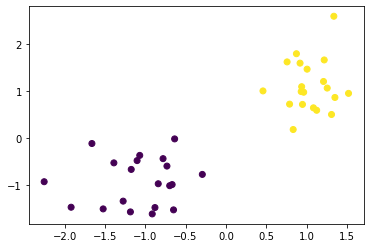

In [36]:
np.random.seed(23)
X, y = arrayGenCla(num_examples = 20, num_inputs = 2, num_class = 2, deg_dispersion = [2, 0.5])
plt.scatter(X[:, 0],X[:, 1],c=y)

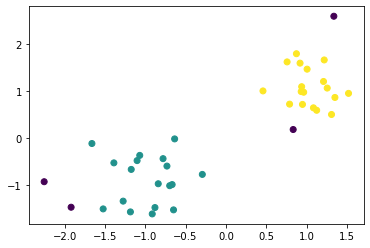

In [37]:
DB = DBSCAN(eps=0.5, min_samples=5).fit(X)
plt.scatter(X[:,0], X[:,1], c = DB.labels_)

In [34]:
DB.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1])

&emsp;&emsp;能够发现，DBSCAN舍弃了一些点（噪声点，标签为-1），并且将数据聚成两类。当然我们也可以尝试减少eps、提高min_samples：

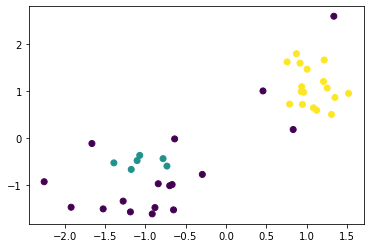

In [38]:
DB = DBSCAN(eps=0.4, min_samples=6).fit(X)
plt.scatter(X[:,0], X[:,1], c = DB.labels_)

此时出现了更多的噪声点，而如果降低密度要求，则会有更多的点被划分到不同的簇中。

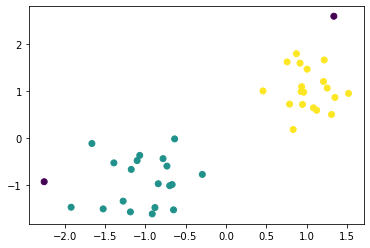

In [39]:
DB = DBSCAN(eps=0.6, min_samples=4).fit(X)
plt.scatter(X[:,0], X[:,1], c = DB.labels_)

&emsp;&emsp;至此，我们就完成了DBSCAN算法从理论到实践的全过程。还是需要值得一提的是，由于聚类算法的特殊性，导致聚类算法本身的原理和应用难度都远低于有监督学习算法，并且在实际进行聚类的过程中，选择算法的过程要重于调参的过程，而且该过程需要加入实际业务背景作为聚类效果好坏评估的更加具体的指导意见。目前介绍的K-Means和DBSCAN，能够在实际分类性能上形成很好的互补，建议在使用的过程中先尝试K-Means，如效果不佳，则可考虑尝试使用DBSCAN进行聚类。